<br>
<font size="4">
<p>
#  Métodos de ensamble

NOTA: para poder visualizar los grafos de los árboles de decisión es necesario instalar pydot y graphviz con los siguientes comandos:

Si se tienen permisos de usuario:

sudo apt-get install graphviz 

pip install pydot

Si no se tienen permisos de usuario, pero se tiene anaconda:

conda install graphviz

pip install pydot

## Método de ensamble - Definición
Son métodos que permiten obtener un consenso de las predicciones de varios modelos[1]. Para ello se tienen en cuenta los siguientes conceptos:

- Exactitud: El ensamble funciona bien si cada uno de los modelos tiene una baja tasa de error.

- Diversidad: El ensamble funciona bien si cada modelo comete errores diferentes.

<img src="imgs/hipotesisensamble.png" width="600" height="400">

Una hipótesis es una función que describe un comportamiento respecto a una serie de muestras. Por ejemplo, una función para definir si un correo es SPAM o no, en la cual ingresa una muestra como texto y se obtiene una salida binaria.  

Los modelos de Machine Learning no son perfectos, tendiendo a poseer diferentes hipótesis dependiendo de factores como el tipo de modelo elegido, el origen y naturaleza de los datos (balance entre las clases, método de preprocesamiento de los datos). Por ello, al usar un modelo para hacer predicciones sobre un conjunto de muestras se pueden obtener resultados diferentes a los de otro modelo sobre las mismas muestras. Si ambos modelos funcionan relativamente bien, se puede hacer un consenso sobre las predicciones para obtener un resultado aproximado a la hipótesis real que existe en los datos.

En la imagen se tienen 3 clasificadores c1, c2 y c3, cada uno con una hipótesis asociada (h1, h2 y h3), las cuales generan predicciones diferentes para el mismo conjunto de datos. Si consideramos sólo uno de los clasificadores, vamos a estar relativamente alejados de la hipótesis real. Sin embargo, si hacemos un consenso entre las tres hipótesis h1, h2 y h3 podemos obtener una aproximación a la hipótesis real f, que a su vez conlleva a predicciones mejores.



## Carga y preprocesamiento de datos

En este tutorial se entrenarán varios ensambles con diferentes estrategias. Para ello se utilizará un dataset que contiene información de 30000 pagos de deudas bancarias para verificar si la persona será capaz de pagar o no la siguiente cuota.

Los datos de entrenamiento se pueden descargar de la página de la [Universidad de California, Irvine](https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls) (Yeh, 2009)

***NOTA:Para evitar problemas por el nombre del archivo (tiene espacios), por favor renombrarlo a credit_card.xls.***

De acuerdo al estudio, la siguiente es la información del estudio:

Esta investigación empleó una variable binaria, el pago por defecto (Sí = 1, No = 0), como la variable de respuesta. Este estudio revisó la literatura y utilizó las siguientes 23 variables como variables explicativas:

- X1: Monto del crédito dado (dólar NT): incluye tanto el crédito al consumo individual como su crédito familiar (suplementario).
- X2: Género (1 = masculino, 2 = femenino).
- X3: Educación (1 = escuela de postgrado, 2 = universidad, 3 = secundaria, 4 = otros).
- X4: Estado civil (1 = casado, 2 = soltero, 3 = otros).
- X5: Edad (año).
- X6 - X11: Historial de pago anterior. Seguimos los últimos registros de pagos mensuales (de abril a septiembre de 2005) de la siguiente manera: X6 = el estado de pago en septiembre de 2005; X7 = estado de reembolso en agosto de 2005; . . . X11 = el estado de pago en abril de 2005. La escala de medición para el estado de pago es: -1 = pagar debidamente; 1 = retraso de pago de un mes; 2 = retardo de pago por dos meses; . . . 8 = retardo de pago por ocho meses; 9 = retraso de pago por nueve meses y más.
- X12-X17: Monto del estado de cuenta (dólar NT). X12 = monto del estado de cuenta en septiembre de 2005; X13 = monto del estado de cuenta en agosto de 2005; . . . X17 = monto del estado de cuenta en abril de 2005.
- X18-X23: Monto del pago anterior (dólar NT). X18 = cantidad pagada en septiembre de 2005; X19 = cantidad pagada en agosto de 2005; . . X23 = cantidad pagada en abril de 2005.

Lo primero que se hace es importar las librerías necesarias.

In [0]:
from keras import backend

In [0]:
# Librerias numericas y de preprocesamiento
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Modelos a usar (Random forest, AdaboostClassifier,GradientBoostingClassifier,Support Vector Machine con Kernel RBF)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score

#Librerias para la Division del dataset en Training y validacion
from sklearn.model_selection import train_test_split

#Visualizacion de arboles
from sklearn.tree import export_graphviz
from IPython.display import Image as PImage
import pydot

# Libreria para determinar que tan bueno es el modelo con valores no observados
from sklearn.metrics import accuracy_score

#SVC para el taller
from sklearn.svm import SVC

<br>
<font size="4">
<p>
El archivo se encuentra en formato xls, así que se convierte en dataframe usando pandas.

In [0]:
df = pd.read_excel('datasets/credit_card.xls',skiprows=1)
df = df.drop('ID', 1)
df.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,100000,2,2,2,23,0,-1,-1,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,140000,2,3,1,28,0,0,2,0,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,20000,1,3,2,35,-2,-2,-2,-2,-1,...,0,13007,13912,0,0,0,13007,1122,0,0


In [0]:
df.dtypes

LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object

<br>
<font size="4">
<p>
A pesar de que en la página del dataset se afirma que no existen valores nulos, es necesario verificar que no haya valores sin asignar (nulos) dentro del dataFrame.

In [0]:
df.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

<br>
<font size="4">
<p>
Podemos usar el paquete seaborn para determinar que tan correlacionadas están las características.

/home/jodrodriguezpo/anaconda2/envs/tensorflowgpu/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


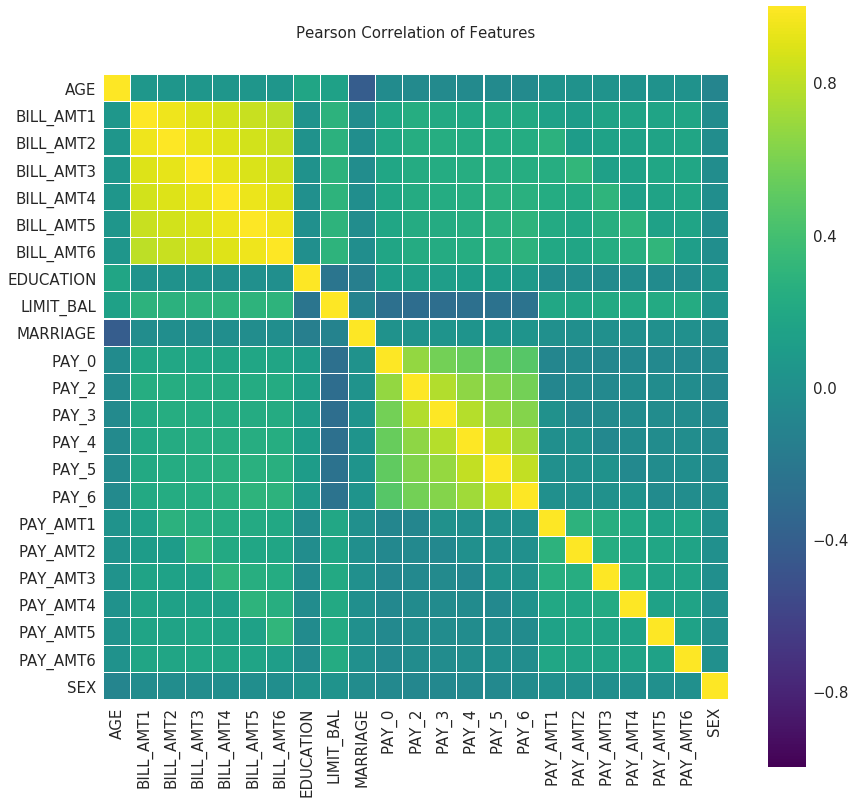

In [0]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,14))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df[df.columns.difference(['default payment next month'])].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=False)

<br>
<font size="4">
<p>
Es notable el hecho de que las caracteristicas relacioandas a historial de pago anterior (PAY_0 a PAY_6) se encuentran bastante correlacionadas. Lo mismo pasa con el monto de estado de cuenta (BILL_AMT). Sin embargo el monto de pago anterior (PAY_AMT) no cumple el mismo patrón. 


***NOTA: En este ejercicio no realizaremos one_hot_encoding de los atributos para poder observar cuales son más importantes que otros.***

Para hacer más fácil el manejo de los datos, vamos a renombrar la columna 'default payment next month' a 'default' en el dataframe. También vamos a cambiar sus valores de 1 y 0 a 1 y -1 respectivamente.

In [0]:
df = df.rename(columns={'default payment next month' : 'default'})

df['default'].replace([0], -1,inplace=True)
df['default'].replace([1], 1,inplace=True)

df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,-0.557600
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.830124
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,-1.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,-1.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,-1.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,-1.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


<br>
<font size="4">
<p>
## Partición de datos de entrenamiento y de test

Se va a hacer una partición de los datos de forma aleatoria, de modo que un tercio de las muestras se usara para test y el resto para entrenar los ensambles. Para ello se usa train_test_split().

Las características consisten en las columnas diferentes de "default". Las clases están dadas por la columna "default".


In [0]:
caract = df[df.columns.difference(['default'])].values
clases = df.loc[:, 'default'].values
x_train, x_test, y_train, y_test = train_test_split(caract,clases, test_size = 0.33, random_state = 0)

nombres_columnas = list(df.columns.values)

<br>
<font size="4">
<p>
## Helper para llamar clasificadores

Se crea una clase helper llamada SklearnHelper para poder llamar los métodos de los módulos de sklearn de una forma más cómoda, dependiendo de un diccionario de parámetros para hacer la fase de entrenamiento.

In [0]:
# Variables utiles para entrenamiento
ntrain = x_train.shape[0]
ntest = x_test.shape[0]
SEED = 0 # Semilla aleatoria para obtener siempre los mismos resultados
NFOLDS = 5 # Numero de folds para entrenamiento con Stacking
kf = KFold(n_splits=NFOLDS,random_state=SEED)

# Clase que extiende la funcionalidad de modulos Sklearn
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self):
        return(self.clf.feature_importances_)

<br>
<font size="4">
<p>
## Bagging

Es un método que se basa en Bootstrap:

Bootstrap es un método para generar nuevos conjuntos de muestras a partir de un grupo original, usando muestreo con repetición (Brownlee, 2016):

- Se tiene un conjunto original de N muestras.
- Se eligen de forma aleatoria muestras del conjunto original hasta formar un nuevo grupo de K muestras. Las muestras elegidas pueden ser repetidas.
- Se repite el proceso de formación de grupos, hasta crear M grupos.

<img src="imgs/bootstrap.PNG" width="600" height="400">

Bootstrap aggregation, más conocido por su contracción Bagging, es un método de ensamble creado por Leo Breiman en 1996 . La idea consiste en entrenar modelos por medio del uso de bootstrap (Breiman, 1996).

Partiendo de un conjunto de entrenamiento se generan varios subconjuntos de entrenamiento usando Bootstrap. Cada uno de estos nuevos subconjuntos se usa para entrenar un modelo diferente, así que es necesario que el número de grupos generado con Bootstrap y el número de modelos del ensamble sea el mismo. Si se quieren hacer predicciones ponderadas es necesario definir el peso de cada modelo por medio de conocimiento experto o el valor de una métrica calculada con conjuntos de validación (para cada modelo su conjunto de validación puede ser obtenido de las muestras que no se seleccionaron para generar su respectivo grupo de muestras de entrenamiento durante el proceso de Bootstrap).

***NOTA: En este tutorial se va a usar Random Forest como representante de Bagging.*** 

Random forest es un caso especial de Bagging haciendo uso de árboles de decisión(Benyamin 2012).

- Cada árbol se genera con un grupo de muestras creado usando Bootstrap.
- Se selecciona un conjunto de características de manera aleatoria.
- En cada nodo se hace un split por la característica que mejor divide los datos (Coeficiente de Gini).

Primero hacemos un diccionario de parámetros para random forest donde se tienen los siguientes parámetros:

- n_estimators: Número de árboles en el ensamble: 500.
- n_jobs: Número de trabajos en paralelo, dependiente del procesador: -1.
- max_depth: Profundidad máxima de los árboles. Debe ser un número pequeño para evitar overfitting.
- min_samples_leaf: Número de muestras en un nodo: 2.
- max_features: máximo número de características seleccionado para crear un árbol. En este caso corresponde con la raíz cuadrada del número de características (4.79).
- verbose: Mostrar información del proceso de entrenamiento : 0.


In [0]:
# Parametros de Random Forest
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

<br>
<font size="4">
<p>
Con los parámetros descritos se genera y se entrena un random forest.

In [0]:
# Creacion del random forest con los parametros dichos
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
rf.train(x_train,y_train)

<br>
<font size="4">
<p>
A continuación se presenta la visualización de dos de los árboles que se encuentran dentro del ensamble. Presionar doble click sobre las imagen permitirá verlas detalladamente y descubrir que la ramificación es diferente.

In [0]:
print "numero de caracteristicas en arbol 0: ",rf.clf.estimators_[0].n_features_

numero de caracteristicas en arbol 0:  23


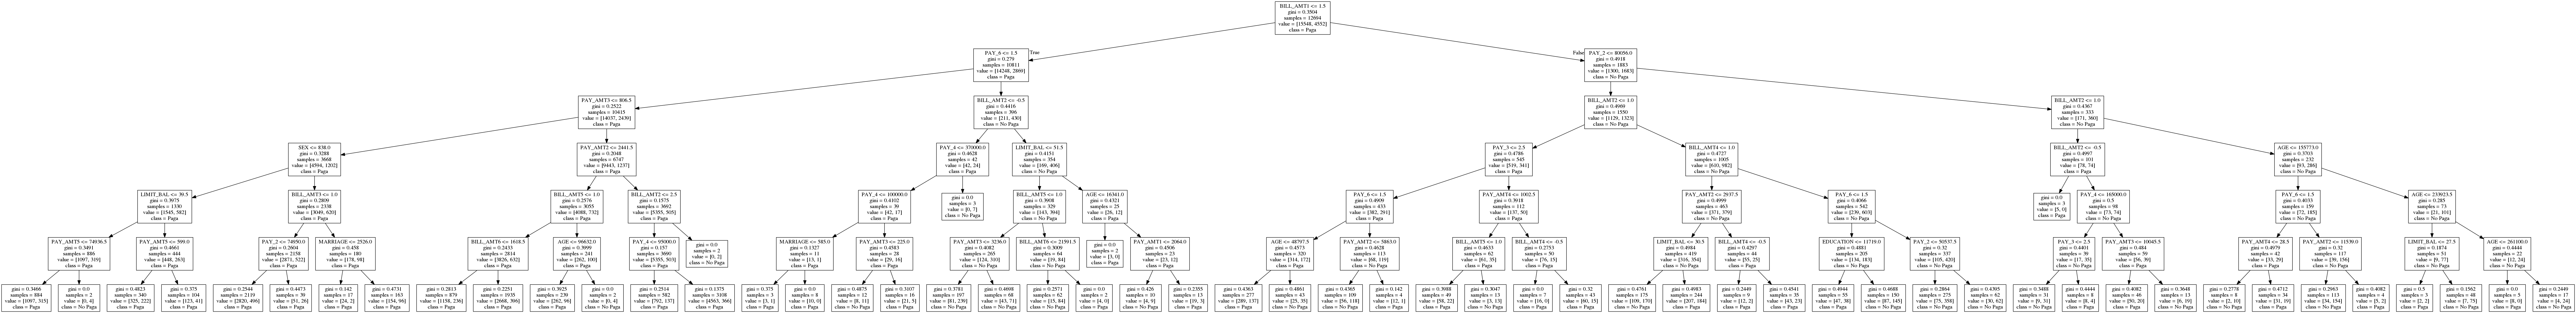

In [0]:
# Exportar el modelo a .dot
export_graphviz(rf.clf.estimators_[0],'rftree1.dot',max_depth=6,class_names=['Paga','No Paga'],feature_names=[nombre for nombre in nombres_columnas if nombre != 'default'])

(graphrf1,) = pydot.graph_from_dot_file('rftree1.dot')
graphrf1.write_png('rftree1.png')

PImage("rftree1.png")

In [0]:
print "numero de caracteristicas en arbol 498: ",rf.clf.estimators_[498].n_features_

numero de caracteristicas en arbol 498:  23


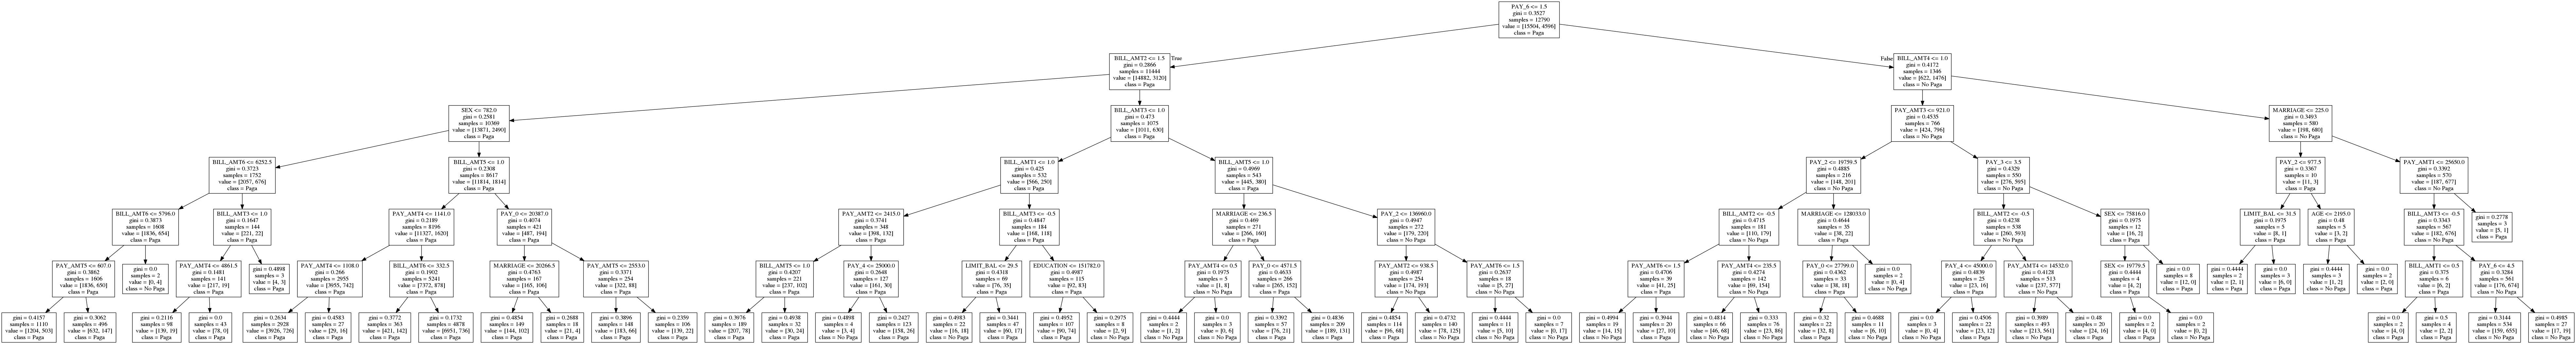

In [0]:
# Exportar el modelo a .dot
export_graphviz(rf.clf.estimators_[498],'rftree2.dot',max_depth=6,class_names=['Paga','No Paga'],feature_names=[nombre for nombre in nombres_columnas if nombre != 'default'])

(graphrf1,) = pydot.graph_from_dot_file('rftree2.dot')
graphrf1.write_png('rftree2.png')

PImage("rftree2.png")

<br>
<font size="4">
<p>
Si medimos el accuracy de estos árboles con los datos de prueba obtenemos valores muy bajos en comparación al ensamble completo.

In [0]:
prediccion_rf1 = rf.clf.estimators_[0].predict(x_test)
prediccion_rf2 = rf.clf.estimators_[498].predict(x_test)
prediccion_ensamble = rf.predict(x_test)

print "Accuracy arbol 0: ",accuracy_score(y_test, prediccion_rf1, normalize = True)
print "Accuracy arbol 498: ",accuracy_score(y_test, prediccion_rf2, normalize = True)
print "Accuracy ensamble: ",accuracy_score(y_test, prediccion_ensamble, normalize = True)

Accuracy arbol 0:  0.070202020202
Accuracy arbol 498:  0.0730303030303
Accuracy ensamble:  0.821818181818


<br>
<font size="4">
<p>
Se observa la importancia de las características usando seaborn:

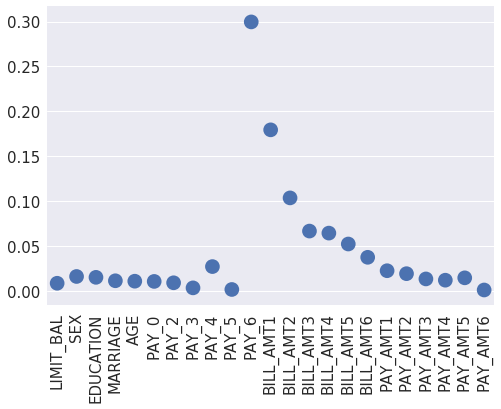

In [0]:
rf_feature = rf.feature_importances().reshape(1,len(nombres_columnas)-1)
rf_dataframe = pd.DataFrame(rf_feature)
rf_dataframe.columns = [nombre for nombre in nombres_columnas if nombre != 'default']

ax_rf = sns.pointplot(data=rf_dataframe, join=False)
plt.xticks(rotation=90)
plt.show()

<br>
<font size="4">
<p>
Para este ensamble la característica más importante fue el historial de pago anterior en el mes de abril de 2005. Los historiales de montos para los meses anteriores fueron las caracteristicas que le continuaron en orden de importancia.

<br>
<font size="4">
<p>
## Boosting

Es un método en ensamble creado por Freund y Schapire en 1996, con las siguientes características(Freund & Schapire, 1995):
- Se usa un sistema de pesos sobre las muestras de entrenamiento.
- Los modelos se entrenan secuencialmente, cambiando los pesos de las muestras dependiendo de los errores cometidos por el anterior clasificador.
- La predicción se calcula como un promedio ponderado sobre todos los modelos del ensamble, siendo cada modelo uno débil (predice ligeramente mejor que random).

<img src="imgs/boostingpasos.png" width="600" height="400">

Para entrenar un ensamble con boosting, se comienza con un conjunto de entrenamiento que se pasa por el modelo 1. Antes de pasarlo, se aplica un peso por muestra para indicar que tanta ganancia de información brinda esa muestra, En la gráfica observamos a estas muestras con pesos representadas por el círculo naranja que dice muestra original. Inicialmente los pesos para cada muestra son iguales, generalmente dados por la expresión $1/K$, donde $K$ es la cantidad de muestras de entrenamiento. Esos pesos son diferentes de los pesos ⍺m, ya que los pesos ⍺m  son uno por cada modelo y los mencionados en este párrafo son uno por cada muestra de entrenamiento.

Dados los errores de clasificación cometidos por el modelo 1 se obtiene un peso $⍺1$ que indicará que tan importante es ese modelo para el ensamble. Esos errores de clasificación también permitirán actualizar los pesos de las muestras de entrenamiento, de modo que el modelo 2 no cometa los mismos errores de entrenamiento.

Como se mencionó, los datos con nuevos pesos ingresan al modelo 2, de ahí se obtiene un peso $⍺2$ que indica la importancia del modelo 2 para el ensamble. También se actualizan los pesos de las muestras de entrenamiento para pasarlas al modelo 3, repitiendo el mismo proceso que se hizo del modelo 1 al modelo 2.

Este proceso se repite hasta completar todos los modelos, lo que en términos del ensamble quiere decir hallar todos los pesos ⍺m  a la vez que se entrenan los modelos con otros pesos cambiantes en las muestras de entrenamiento. 

Para tomar una decisión se hace un promedio ponderado de las predicciones de los modelos:

<img src="imgs/boostingpredicion.PNG" width="300" height="300">

En este ejercicio vamos a utilizar la forma más conocida: Adaboost. Para ello usamos un módulo de Sklearn.

<img src="imgs/adaboostalgo.PNG" width="600" height="400">

Los parámetros de este ensamble serán 500 estimadores y una tasa de aprendizaje (paso de actualización) de 0.75. En la implementación de Sklearn cada estimador corresponde con un árbol de decisión.

In [0]:
# Parametros de AdaBoost 
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

In [0]:
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
ada.train(x_train,y_train)

<br>
<font size="4">
<p>
A continuación se presenta la visualización de dos de los árboles que se encuentran dentro del ensamble. Presionar doble click sobre las imagen permitirá verlas detalladamente y descubrir que la ramificación es diferente.

In [0]:
print "numero de caracteristicas en arbol 0: ",ada.clf.estimators_[0].n_features_

numero de caracteristicas en arbol 0:  23


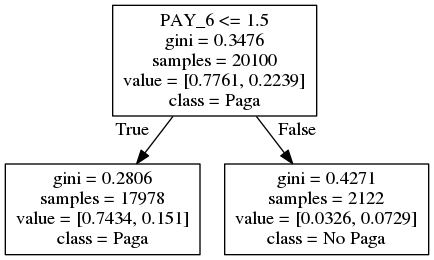

In [0]:
# Exportar el modelo a .dot
export_graphviz(ada.clf.estimators_[0],'adatree1.dot',max_depth=6,class_names=['Paga','No Paga'],feature_names=[nombre for nombre in nombres_columnas if nombre != 'default'])

(graphada1,) = pydot.graph_from_dot_file('adatree1.dot')
graphada1.write_png('adatree1.png')

PImage("adatree1.png")

In [0]:
print "numero de caracteristicas en arbol 498: ",ada.clf.estimators_[498].n_features_

numero de caracteristicas en arbol 498:  23


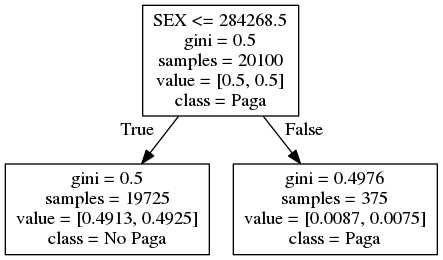

In [0]:
# Exportar el modelo a .dot
export_graphviz(ada.clf.estimators_[498],'adatree2.dot',max_depth=6,class_names=['Paga','No Paga'],feature_names=[nombre for nombre in nombres_columnas if nombre != 'default'])

(graphada1,) = pydot.graph_from_dot_file('adatree2.dot')
graphada1.write_png('adatree2.png')

PImage("adatree2.png")

<br>
<font size="4">
<p>
El número de caracteristicas presentado en ambos árboles (23) corresponde con el número de características originales de las que se partieron para generar los nuevos árboles. Recordando que cada modelo tiene que ser débil, una forma de lograrlo es que cada uno sea un árbol de muy poca profundidad.

Puede darse el caso de que alguno de los estimadores tenga mejores predicciones que el ensamble. En este caso el árbol 0 que divide los datos por historial de pago anterior en el mes de abril de 2005 obtiene mejores resultados que el ensamble completo (para que estos resultados sean reproducibles se aplica la semilla aleatoria 0, tanto a nivel de separación en entrenamiento y validación, como generación de árboles).

In [0]:
prediccion_ada1 = ada.clf.estimators_[0].predict(x_test)
prediccion_ada2 = ada.clf.estimators_[498].predict(x_test)
prediccion_ensamble = ada.predict(x_test)

print "Accuracy arbol 0: ",accuracy_score(y_test, prediccion_ada1, normalize = True)
print "Accuracy arbol 498: ",accuracy_score(y_test, prediccion_ada2, normalize = True)
print "Accuracy ensamble: ",accuracy_score(y_test, prediccion_ensamble, normalize = True)

Accuracy arbol 0:  0.826161616162
Accuracy arbol 498:  0.226464646465
Accuracy ensamble:  0.82101010101


<br>
<font size="4">
<p>
A continuación se presenta la importancia de las características para este ensamble.

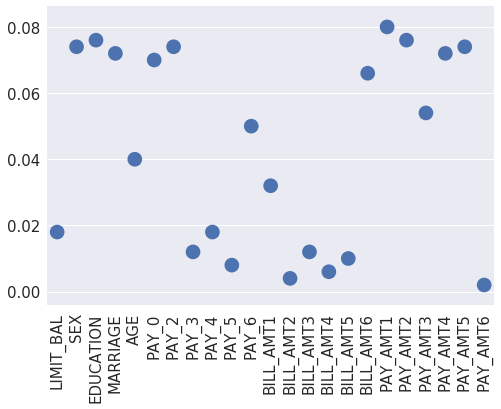

In [0]:
ada_feature = ada.feature_importances().reshape(1,len(nombres_columnas)-1)
ada_dataframe = pd.DataFrame(ada_feature)
ada_dataframe.columns = [nombre for nombre in nombres_columnas if nombre != 'default']

ax_ada = sns.pointplot(data=ada_dataframe, join=False)
plt.xticks(rotation=90)
plt.show()

<br>
<font size="4">
<p>
Es destacable el hecho de que a pesar de que la característica PAY_6 (historial de pago anterior en el mes de abril de 2005) no es tan importante para el ensamble de Boosting como el de Bagging, al usarla se pueden obtener buenos resultados para un modelo singular.

<br>
<font size="4">
<p>
## Stacking

Es un método de ensamble en el cual la salida de un modelo se usa directamente como la entrada de otro modelo. 

<img src="imgs/stacking.png" width="900" height="400">

Para entrenar con Stacking se entrena por niveles. El primero modelo se entrena con los datos de entrenamiento originales y las etiquetas correspondientes. El modelo 2 se entrena con la salida del modelo 1 como características y las etiquetas originales, así sucesivamente hasta llegar al modelo 3.

Para evitar overfitting, una de las estrategias posibles se basa en el uso de una división en K folds del conjunto de entrenamiento en un estilo similar a cross-validation:
- El modelo 1 se entrena con un subset de los datos de entrenamiento, el cual corresponde con K-1 folds. Se generan predicciones para el fold sobrante con este modelo. 
- Con las nuevas predicciones para el fold sobrante se entrena el modelo 2: si es un modelo de dos niveles se utilizan como etiquetas de clases las originales que tenían estas muestras en el conjunto de entrenamiento y como características las nuevas predicciones del modelo 1. 
- Si el modelo es de más niveles se siguen calculando folds en la misma forma, de modo que no se repitan datos de entrenamiento entre cada modelo.

La siguiente función permite generar muestras de entrenamiento para el siguiente nivel usando Kfolding (kf, una variable descrita arriba para generar folds). A la vez se entrena el modelo del nivel actual por medio de un formato similar a cross_validation.

Esta función recibe como parámetros el modelo (clf), las características de las muestras de entrenamiento (x_train), las clases de entrenamiento (y_train) y las características del conjunto de pruebas (x_test). Como retorno devuelve las predicciones que servirán de características para entrenar el siguiente modelo y las características para evaluarlo.

In [0]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

<br>
<font size="4">
<p>
La estrategia de Stacking a usar es la siguiente:
    
<img src="imgs/stackingpractica.png" width="900" height="400">

Como los ensambles anteriores fueron entrenados con todo el conjunto de entrenamiento, se crean unos nuevos. Esto puede durar algunos minutos, ya que la función aplica cross-validation para hallar los datos para el siguiente nivel.

In [0]:
rf_stack = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
ada_stack = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)

rf_oof_train, rf_oof_test = get_oof(rf_stack,x_train, y_train, x_test)
print "Finalizado entrenamiento Random Forest"
ada_oof_train, ada_oof_test = get_oof(ada_stack, x_train, y_train, x_test)
print "Finalizado entrenamiento AdaBoost"

Finalizado entrenamiento Random Forest
Finalizado entrenamiento AdaBoost


<br>
<font size="4">
<p>
Con estas predicciones se entrena un modelo de Boosting conocido como Gradient Boosting. Para este caso, puede que un modelo más sencillo hubiese sido suficiente, sin embargo, la idea es mostrar que ensambles y stacking se pueden combinar de cualquier manera.

In [0]:
# Parametros de Gradient Boosting
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)

x_train_gb = np.concatenate((rf_oof_train, ada_oof_train), axis=1)
x_test_gb = np.concatenate(( rf_oof_test, ada_oof_test), axis=1)

gb.fit(x_train_gb,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=2,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)

<br>
<font size="4">
<p>
Para probarlo se hacen predicciones con el conjunto de pruebas obtenido de get_oof. Estas predicciones se miden con las etiquetas originales y_test, usando la métrica accuracy. En este caso, el accuracy es mejor alrededor del orden $10^{-3}$ que en los métodos de Bagging y Boosting por separado.   

In [0]:
prediccion_gb = gb.predict(x_test_gb)

print "Accuracy Stacking ",accuracy_score(y_test, prediccion_gb, normalize = True)

Accuracy Stacking  0.822222222222


#  TALLER
<BR>
<font size="4">
La tarea consiste en detectar si masas encontradas en mamografías son benignas o malignas. Para hacerlo, se requiere implementar un stack compuesto de la siguiente forma:

- Nivel 1: Un método de ensamble de Boosting por medio de AdaBoost.
- Nivel 2: Un Support Vector Machine lineal con parametro C = 0.025.

Los datos del dataset se pueden obtener de la página de la [Universidad de California, Irvine](https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data) (Elter & Wittenberg, 2007). Los atributos para las 961 muestras son los siguientes:

1. BI-RADS assessment: 1 to 5 (ordinal, non-predictive!) 
2. Age: patient's age in years (integer) 
3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal) 
4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal) 
5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal) 
6. Severity: benign=0 or malignant=1 (binominal, goal field!) 

El atributo 6 nos da la clase de la masa de mamografía, siendo 0 benigno y 1 maligno.

<font size="4">
<p> <b>Punto 1</b><br>

Lea y preprocese el dataset, de modo que no queden valores nulos.Para ello use un dataframe de pandas. 
- Primero nombre las columnas con los nombres que se tienen arriba. 
- Elimine la columna BI-RADS del dataframe, ya que no es predictiva.
- Compruebe que no existan valores nulos o caracteres '?'. En caso de que estos valores existan, reemplacelos por el valor que más veces aparece en la columna (característica) correspondiente. 
- Imprima los tipos de datos de las columnas del dataframe con el atributo dtypes. Si las características Age, Shape, Margin y Density aparecen del tipo 'object', conviertalas a entero usando el siguiente código por cada columna:
$$\text{nombre_dataframe['nombre_columna']} = \text{pd.to_numeric(nombre_dataframe['nombre_columna'])}$$ 
- Convierta las columnas categóricas Shape y Margin al formato one-hot-encoding usando la función get_dummies de los dataframes de Pandas. 
- Cambie la etiqueta 0 por -1 y la etiqueta 1 por 1 en el atributo Severity.

Solución:

In [0]:
#Lectura y nombramiento de las columnas
taller_df = pd.read_csv('datasets/mammographic_masses.data',delimiter=',',header=None)

taller_df.columns = ['BI-RADS','Age','Shape','Margin','Density','Severity']
taller_df.head(10)

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1
5,4,65,1,?,3,0
6,4,70,?,?,3,0
7,5,42,1,?,3,0
8,5,57,1,5,3,1
9,5,60,?,5,1,1


In [0]:
#Eliminacion de la columna BI-RADS
taller_df = taller_df.drop('BI-RADS', 1)
taller_df.head(10)

,Age,Shape,Margin,Density,Severity
0,67,3,5,3,1
1,43,1,1,?,1
2,58,4,5,3,1
3,28,1,1,3,0
4,74,1,5,?,1
5,65,1,?,3,0
6,70,?,?,3,0
7,42,1,?,3,0
8,57,1,5,3,1
9,60,?,5,1,1


In [0]:
#Comprobacion de caracteres nulos 
taller_df.isnull().sum()

Age         0
Shape       0
Margin      0
Density     0
Severity    0
dtype: int64

In [0]:
#Comprobación de caracteres ?
for value in  ['Age','Shape','Margin','Density']:
    print value,":", sum(taller_df[value] == '?')

Age : 5
Shape : 31
Margin : 48
Density : 76


In [0]:
#Reemplazo de caracteres ? por el valor que mas se repite en la columna
for value in ['Age','Shape','Margin','Density']:
    taller_df[value].replace(['?'], [taller_df.describe(include='all')[value][2]],
                                inplace=True)

    print value,":", sum(taller_df[value] == '?')


Age : 0
Shape : 0
Margin : 0
Density : 0


In [0]:
#Imprimendo tipos de columnas    
print taller_df.dtypes
for value in ['Age','Shape','Margin','Density']:
    taller_df[value] = pd.to_numeric(taller_df[value])

Age         object
Shape       object
Margin      object
Density     object
Severity     int64
dtype: object


In [0]:
#Haciendo conversion de Age, Shape, Margin, Density a entero:
for value in ['Age','Shape','Margin','Density']:
    taller_df[value] = pd.to_numeric(taller_df[value])
print taller_df.dtypes

Age         int64
Shape       int64
Margin      int64
Density     int64
Severity    int64
dtype: object


In [0]:
#Conversion de Shape y Margin a one-hot-encoding
taller_df = pd.get_dummies(taller_df, columns=['Shape','Margin'])

taller_df.describe(include="all")


,Age,Density,Severity,Shape_1,Shape_2,Shape_3,Shape_4,Margin_1,Margin_2,Margin_3,Margin_4,Margin_5
count,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000
mean,55.505723,2.917794,0.463059,0.233091,0.219563,0.098855,0.448491,0.421436,0.024974,0.120708,0.291363,0.141519
std,14.444586,0.365869,0.498893,0.423020,0.414166,0.298623,0.497599,0.494046,0.156127,0.325957,0.454627,0.348738
min,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,57.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,66.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,96.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Reemplazo de las etiquetas 0 
taller_df['Severity'].replace([0], -1,inplace=True)
taller_df['Severity'].replace([1], 1,inplace=True)
taller_df['Severity'].describe()

count    961.000000
mean      -0.073881
std        0.997786
min       -1.000000
25%       -1.000000
50%       -1.000000
75%        1.000000
max        1.000000
Name: Severity, dtype: float64

<font size="4">
<p> <b>Punto 2</b><br>

Entrenamiento del primer nivel:
- Divida el dataset en conjuntos de entrenamiento y test, como se realizó en la sección Partición de datos de entrenamiento y de test (30% test, 70% training).
- Cree un clasificador de tipo AdaBoost con la clase SKlearnHelper descrita anteriormente. Use 400 estimadores, una semilla aleatoria con valor de cero y un learning rate de 0.75.
- Se brinda la función get_oof_taller que sirve para entrenar el modelo AdaBoost y a la vez obtener las muestras para entrenar el siguiente nivel (SVM lineal). Esta función recibe como parámetros el modelo (clf), las características de las muestras de entrenamiento (x_train), las clases de entrenamiento (y_train) y las características del conjunto de pruebas (x_test). Como retorno devuelve las predicciones que servirán de características para entrenar el siguiente modelo y las características para evaluarlo, de la misma forma que la función get_oof original. Usela para entrenar el modelo AdaBoost creado y para generar las muestras de entrenamiento y pruebas del siguiente nivel (SVM). 

In [0]:
def get_oof_taller(clf, x_train, y_train, x_test):
    ntrain = len(x_train)
    ntest = len(x_test)
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    kf_taller = KFold(n_splits=NFOLDS,random_state=SEED)

    for i, (train_index, test_index) in enumerate(kf_taller.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

<font size="4">
Solución

In [0]:
#Division del dataset
caract_taller = taller_df[taller_df.columns.difference(['Severity'])].values
clases = taller_df.loc[:, 'Severity'].values
x_train_taller, x_test_taller, y_train_taller, y_test_taller = train_test_split(caract_taller,clases, test_size = 0.33, random_state = 0)

In [0]:
#Creacion del clasificador Adaboost
#Parametros
ada_params_taller = {
    'n_estimators': 400,
    'learning_rate' : 0.75
}
ada_taller = SklearnHelper(clf=AdaBoostClassifier, seed=0, params=ada_params_taller)

In [0]:
#Uso de get_oof_taller para entrenar AdaBoost y obtener las muestras de entrenamiento y test del SVM 

ada_oof_train_taller, ada_oof_test_taller = get_oof_taller(ada_taller, x_train_taller, y_train_taller, x_test_taller)

<font size="4">
<p> <b>Punto 3</b><br>
Nivel 2, Support Vector Machine:
- Cree un Support Vector Machine lineal con parametro C = 0.025, usando la clase SKlearnHelper (Semilla aleatoria = 0). 
- Entrénelo con las características de entrenamiento obtenidas de get_oof_taller y el arreglo de clases de entrenamiento que obtuvo al dividir el dataset.
- Mida el accuracy del stack por medio de predicciones con el SVM lineal sobre el conjunto de prueba obtenido de la función get_oof_taller.

Solución:

In [0]:
#Parametros del SVM lineal
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }
#Creacion del SVM lineal
svm_taller = SklearnHelper(clf=SVC, seed=0, params=svc_params)

In [0]:
#Entrenamiento del SVM con caracteristicas obtenidas de get_oof_taller
svm_taller.fit(ada_oof_train_taller,y_train_taller)

SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
#Predicciones sobre el conjunto de prueba obtenido de get_oof 
predicciones_stack_taller = svm_taller.predict(ada_oof_test_taller)
print "Accuracy stack: ",accuracy_score(y_test_taller, predicciones_stack_taller, normalize = True)

Accuracy stack:  0.776729559748


# - QUIZ
<BR>
<font size="4">
<p> <b>Pregunta 1</b><br>
¿Cuál de las siguientes acciones se puede realizar con un ensamble con Bagging pero no con un ensamble con Boosting?
</p>
<br>
<b>Respuesta</b>
<ul>
<li>***Entrenar varios modelos en paralelo partiendo de diferentes conjuntos de muestras obtenidos por bootstrap.***
<li>Usar como modelos individuales árboles de diferente profundidad.
<li>Usar modelos individuales de diferente naturaleza como Naive Bayes, Support Vector Machine y Árboles de decisión para realizar el consenso de las predicciones.
</ul>
</font>

Justificación: Los modelos de ensambles con Bagging son independientes, debido a que después de la selección con repetición de muestras para entrenar cada modelo la única interacción que se tiene es el cálculo del consenso para predicciones futuras. En otras palabras, el muestreo con repetición y el entrenamiento de cada modelo no afecta al entrenamiento de otro modelo. Solamente las predicciones de cada modelo afectan al ensamble. En cambio, Boosting requiere que los modelos se entrenen secuencialmente para que unos no cometan los mismos errores que modelos anteriores, los cuales están dados por los pesos $w_i$ obtenidos luego de entrenar cada modelo.
No hay restricciones en ninguno de los dos tipos de ensamble respecto a la naturaleza y características de los modelos individuales.

<BR>
<font size="4">
<p> <b>Pregunta 2</b><br>
Si se hace un ensamble de diferentes tipos de modelos  (Naive Bayes, Support Vector Machine y Árboles de decisión, etc)¿Es necesario hallar los valores óptimos de los hiperparámetros de los modelos individualmente?. Por ejemplo, en un SVM con kernel Gaussiano, el valor de Gamma y el valor de C son hiperparámetros.
</p>
<br>
<b>Respuesta</b>
<ul>
<li>***No es necesario***
<li>Si es necesario.
</ul>
</font>

Justificación: Modelos que No tienen los mejores valores de sus hiperparámetros se encuentran en la categoría de modelos débiles. A partir de modelos débiles se pueden obtener buenas predicciones, así que no es necesario optimizar los hiperparámetros de cada modelo.

<br>
<font size="4">
<p>
## Referencias
- Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.
- Brownlee, J. (2016, September 21). Bagging and Random Forest Ensemble Algorithms for Machine Learning. Retrieved August 22, 2017, from https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/
- Breiman, L. (1996). Bagging predictors. Machine learning, 24(2), 123-140. Retrieved August 22, 2017, from https://link.springer.com/content/pdf/10.1007%2FBF00058655.pdf
- Benyamin, D. (2012, November 9). A Gentle Introduction to Random Forests, Ensembles, and Performance Metrics in a Commercial System. CitizenNet Blog. Retrieved August 22, 2017, from http://blog.citizennet.com/blog/2012/11/10/random-forests-ensembles-and-performance-metrics
- Freund, Y., & Schapire, R. E. (1995, March). A desicion-theoretic generalization of on-line learning and an application to boosting. In European conference on computational learning theory (pp. 23-37). Springer, Berlin, Heidelberg. Retrieved August 22, 2017, from http://www.face-rec.org/algorithms/Boosting-Ensemble/decision-theoretic_generalization.pdf.
- Elter, M., Schulz‐Wendtland, R., & Wittenberg, T. (2007, February). The prediction of breast cancer biopsy outcomes using two CAD approaches that both emphasize an intelligible decision process. Medical physics, 34(11), 4164-4172. Retrieved August 22, 2017, from https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data
- - KDnuggets. Stacking Models for Improved Predictions (2017). Retrieved August 23, 2017, from http://www.kdnuggets.com/2017/02/stacking-models-imropved-predictions.html
- Pedregosa, F., Varoquaux, G., Gramfort, A. & Michel, V. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825-2830.
- 3.2.4.3.1. sklearn.ensemble.RandomForestClassifier. (2016, November). Retrieved August 23, 2017, from http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- Sklearn.ensemble.AdaBoostClassifier. (2016, November). Retrieved August 23, 2017, from http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier
- 3.2.4.3.5. sklearn.ensemble.GradientBoostingClassifier. (2016, November). Retrieved August 23, 2017, from http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html